In [15]:
import math
import cv2
import numpy as np
import PreProcess as pre

# Định nghĩa các hằng số dùng cho ngưỡng thích nghi


ADAPTIVE_THRESH_BLOCK_SIZE: Đây là kích thước của khu vực lân cận sẽ được sử dụng để tính ngưỡng cục bộ. Trong trường hợp này, kích thước của khu vực là 19x19 pixel.

Ngưỡng cục bộ (adaptive threshold) là một kỹ thuật được sử dụng để chuyển đổi ảnh xám (grayscale) thành ảnh nhị phân (binary image) dựa trên một ngưỡng được tính toán dựa trên các giá trị pixel trong một khu vực lân cận xung quanh từng điểm ảnh

In [16]:

ADAPTIVE_THRESH_BLOCK_SIZE = 19 



ADAPTIVE_THRESH_WEIGHT: Đây là một hệ số được sử dụng trong phương pháp tính toán ngưỡng cục bộ. Nó ảnh hưởng đến mức độ làm mờ và làm sắc nét ảnh kết quả. Trong trường hợp này, giá trị của hệ số là 9.

In [17]:
ADAPTIVE_THRESH_WEIGHT = 9

In [18]:
# Biến đếm số lượng biển số xe
n = 1  

# Định nghĩa các hằng số dùng cho lọc kí tự
Min_char = 0.01
Max_char = 0.09

In [19]:
import cv2
import numpy as np
import math

# Giả sử bạn đã có img, contours, anh_xam và anh_nhi_phan từ trước
def tachanh(url) :
    img = cv2.imread(url)
    img = cv2.resize(img, dsize=(1920, 1080))
    anh_xam, anh_nhi_phan = pre.tienxuly(img)
    canny_image = cv2.Canny(anh_nhi_phan, 250, 255)  # Tạo ảnh biên bằng phương pháp Canny
    kernel = np.ones((3, 3), np.uint8)  # Tạo kernel cho phép dãn (Tạo ra một kernel có kích thước 3x3 với tất cả các giá trị là 1. Kernel này được sử dụng để xác định cách phép dãn sẽ được áp dụng cho ảnh.)
    dilated_image = cv2.dilate(canny_image, kernel, iterations=1) 

    contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Tìm các đường viền trong ảnh
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]  # Sắp xếp và lấy 10 đường viền có diện tích lớn nhất
    screenCnt = []  # Danh sách các đường viền của biển số xe
    for c in contours:
        peri = cv2.arcLength(c, True)  # Tính chu vi của đường viền
        approx = cv2.approxPolyDP(c, 0.06 * peri, True)  # Làm xấp xỉ đa giác, chỉ giữ đường viền có 4 cạnh
        [x, y, w, h] = cv2.boundingRect(approx.copy())  # Tạo hình chữ nhật bao quanh đa giác
        
        if len(approx) == 4:  # Nếu đường viền có 4 cạnh
            # Kiểm tra xem các đường chéo gần với 90 độ
            angles = []
            for i in range(4):
                pt1 = tuple(approx[i][0])
                pt2 = tuple(approx[(i + 1) % 4][0])
                pt3 = tuple(approx[(i + 2) % 4][0])
                angle = math.degrees(math.atan2(pt3[1]-pt2[1], pt3[0]-pt2[0]) - math.atan2(pt1[1]-pt2[1], pt1[0]-pt2[0]))
                angle = abs(angle) if angle < 180 else 360 - abs(angle)
                angles.append(angle)

            if all(angle > 70 and angle < 100 for angle in angles):
                screenCnt.append(approx)  # Thêm vào danh sách các đường viền của biển số xe
                cv2.putText(img, str(len(approx.copy())), (x, y), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 0), 3)
    if not screenCnt:  # Nếu không có biển số nào được phát hiện
        detected = 0
        print("No plate detected")
    else:
        detected = 1

    if detected == 1:
        for screenCnt in screenCnt:
            cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 3)  # Khoanh vùng biển số xe
            # cv2.imshow("Contours", img)

            ############## Tìm góc của biển số xe #####################
            (x1, y1) = screenCnt[0, 0]
            (x2, y2) = screenCnt[1, 0]
            (x3, y3) = screenCnt[2, 0]
            (x4, y4) = screenCnt[3, 0]
            array = [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
            sorted_array = sorted(array, reverse=True, key=lambda x: x[1])
            (x1, y1) = sorted_array[0]
            (x2, y2) = sorted_array[1]
            doi = abs(y1 - y2)  # Tính độ chênh lệch y
            ke = abs(x1 - x2)  # Tính độ chênh lệch x
            angle = math.atan(doi / ke) * (180.0 / math.pi)  # Tính góc nghiêng của biển số

            ####################################

            ########## Cắt biển số và căn chỉnh đúng góc ################
            mask = np.zeros(anh_xam.shape, np.uint8)  # Tạo mặt nạ với kích thước bằng ảnh gốc
            new_image = cv2.drawContours(mask, [screenCnt], 0, 255, -1)  # Vẽ đường viền biển số lên mặt nạ
            cv2.imwrite("output/mask.jpg", new_image)
            # Cắt ảnh
            (x, y) = np.where(mask == 255)  # Lấy tọa độ của các pixel nằm trong biển số
            (topx, topy) = (np.min(x), np.min(y))  # Tọa độ trên cùng của biển số
            (bottomx, bottomy) = (np.max(x), np.max(y))  # Tọa độ dưới cùng của biển số

            roi = img[topx:bottomx, topy:bottomy]  # Cắt vùng ảnh chứa biển số
            
            imgThresh = anh_nhi_phan[topx:bottomx, topy:bottomy]  # Cắt vùng ảnh ngưỡng chứa biển số
            ptPlateCenter = (bottomx - topx) / 2, (bottomy - topy) / 2  # Tính trung điểm của biển số
            if x1 < x2:
                rotationMatrix = cv2.getRotationMatrix2D(ptPlateCenter, -angle, 1.0)  # Ma trận xoay với góc âm
            else:
                rotationMatrix = cv2.getRotationMatrix2D(ptPlateCenter, angle, 1.0)  # Ma trận xoay với góc dương

            roi = cv2.warpAffine(roi, rotationMatrix, (bottomy - topy, bottomx - topx))  # Xoay ảnh biển số
            imgThresh = cv2.warpAffine(imgThresh, rotationMatrix, (bottomy - topy, bottomx - topx))  # Xoay ảnh ngưỡng biển số
            roi = cv2.resize(roi, (0, 0), fx=3, fy=3)  # Phóng to ảnh biển số
            imgThresh = cv2.resize(imgThresh, (0, 0), fx=3, fy=3)  # Phóng to ảnh ngưỡng biển số     
            # Lưu lại ảnh 
            cv2.imwrite("output/contours_detected.jpg", img)
            cv2.imwrite("output/cropped_plate.jpg", roi)
            cv2.imwrite("output/cropped_threshold_plate.jpg", imgThresh)
    
    return imgThresh


đọc ảnh từ theo thứ tự

In [20]:
import os
from matplotlib import pyplot as plt
import shutil


import cv2
def phantachkytu(path):
    imgThresh=tachanh(path)
    roi = cv2.imread("output/cropped_plate.jpg")
    roi = pre.adjust_brightness_gray(roi)
    kerel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Tạo kernel hình chữ nhật
    thre_mor = cv2.morphologyEx(imgThresh, cv2.MORPH_DILATE, kerel3)  # Áp dụng phép dãn ảnh
    cont, hier = cv2.findContours(thre_mor, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Tìm các đường viền trong ảnh đã dãn
    ##################### Lọc các ký tự #################
    char_x_ind = {}  # Tạo dictionary lưu chỉ số của các ký tự
    char_x = []  # Danh sách lưu tọa độ x của các ký tự
    kichthuoc = cv2.imread("output/cropped_threshold_plate.jpg")
    height, width, _ = kichthuoc.shape  # Lấy kích thước ảnh biển số
    roiarea = height * width  # Tính diện tích ảnh biển số
    for ind, cnt in enumerate(cont):
        (x, y, w, h) = cv2.boundingRect(cont[ind])  # Tạo hình chữ nhật bao quanh ký tự
        ratiochar = w / h  # Tính tỷ lệ chiều rộng / chiều cao của ký tự
        char_area = w * h  # Tính diện tích của ký tự
        if (Min_char * roiarea < char_area < Max_char * roiarea) and (0.1 < ratiochar < 0.7):  # Lọc các ký tự hợp lệ
            if x in char_x:  # Nếu tọa độ x đã tồn tại, tăng x lên 1 để tránh trùng lặp
                x = x + 1
            char_x.append(x)  # Thêm tọa độ x vào danh sách
            char_x_ind[x] = ind  # Lưu chỉ số của ký tự vào dictionary
    # Sắp xếp các tọa độ x theo thứ tự tăng dần
    char_x = sorted(char_x)  
    # Sao chép hình ảnh gốc để vẽ tất cả các hình chữ nhật
    roi_with_rects = roi.copy()
    line1=[]
    line2=[]
    for i in char_x:
        (x, y, w, h) = cv2.boundingRect(cont[char_x_ind[i]])  # Tạo hình chữ nhật bao quanh ký tự
        # Vẽ hình chữ nhật bao quanh ký tự với màu mới
        cv2.rectangle(roi_with_rects, (x, y), (x + w, y + h), (0,255,0), 2)  
        char_image = roi[y:y+h, x:x+w]
        if 4.5 > h / w > 1 and h > height/2.6 and x>1  :      
            if y < height/3 :
                i=1
                char_image = pre.dao_den_thanh_trang(char_image)
                # char_image = add_padding(char_image)
                line1.append(char_image) 
            else :
                i=2
                char_image = pre.dao_den_thanh_trang(char_image)
                # char_image = add_padding(char_image)
                line2.append(char_image)
    
    # Chuyển đổi từ BGR sang RGB để hiển thị bằng Matplotlib
    roi_with_rects_rgb = cv2.cvtColor(roi_with_rects, cv2.COLOR_BGR2RGB)
    plt.imshow(roi_with_rects_rgb,cmap='gray')  # Hiển thị hình ảnh với tất cả các hình chữ nhật
    plt.show()
    return height,width,line1,line2

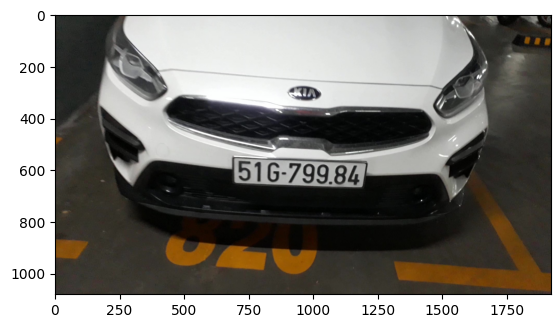

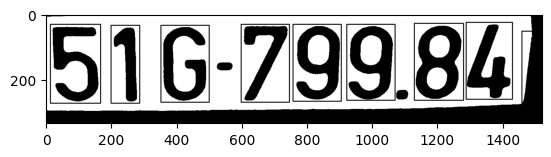

333
1521


In [21]:
import cv2
import matplotlib.pyplot as plt
import PreProcess as pre
path = "D:/Monhoc/AI/TongHopAI/DuDoanBienSo/image/2.jpg"
img=cv2.imread(path)
if img is None:
    print(f"Error: Image at {path} could not be loaded. Please check the path.")
else:
    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(img_rgb, cmap='gray')
    plt.show()

h,w,line1,line2=phantachkytu(path)
print(h)
print(w)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


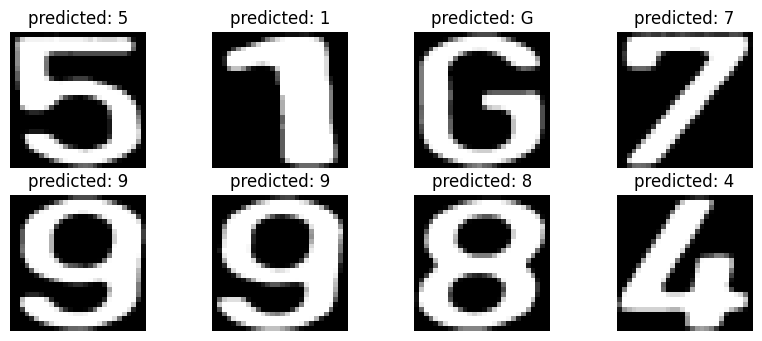

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
51G79984


In [22]:
from tensorflow.keras.models import load_model

# Load the entire model back.
model = load_model('model.keras')
char_list = line1+line2
# Load the saved model
# Predicting the output
def fixdimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for ch in char: # iterating over the characters
        img = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_LINEAR)

        img = fixdimension(img)
        img = img.reshape(1, 28, 28, 3) # preparing image for the model
        y = model.predict(img)[0] # predicting the class
        class_index = np.argmax(y) # get the index of the highest probability class
        character = dic[class_index] # map index to character
        output.append(character) # storing the result in a list

    plate_number = ''.join(output)

    return plate_number
# Get predicted characters
predicted_characters = show_results(char_list)

# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i, ch in enumerate(char_list):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'predicted: {predicted_characters[i]}') # Now predicted_characters is defined
    plt.axis('off')
plt.show()
print(show_results(char_list))
